# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


In [ ]:
data["train"].label.value_counts()
train = data["train"]

ones = train[train["label"] == 1]
zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
data["train"].label.value_counts()

len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Fasttext 1D CNN

In [ ]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel,
                         dict(
                             classifier_dims=256,
                             num_classes=2,
                             n_layers=2,
                             final_layer_builder=fb_1d_loss_builder,
                             gaussian_noise=0.15,
                             dropout=0.2,
                             embedding_dims=256,
                             internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin",
                             featurizer="transformer",
                             loss="focal",
                             dice_loss_coef=0.0,
                             auc_loss_coef=0.0,
                         ),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    model_call_back=reg_sched,
    scheduler_init_fn=scheduler_init_fn,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712

# Lang Features Model

In [ ]:
epochs = 15
batch_size = 256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = [
    "fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"
]  # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = [
    "full_view",
]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.2,
                              embedding_dims=256,
                              internal_dims=512,
                              capabilities=all_caps,
                              featurizer="transformer",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              n_layers=2,
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# BERT Models

## Actibus/Bert_REview

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.761	0.749 (0.703	0.691)


## NSP Style Finetuned

### Non DETR

In [ ]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.5, # 0.25
                              dropout=0.2,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=3,
                              n_tokens_in=96,
                              n_tokens_out=32,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# Try with_replacement

# 0.799	0.639 (0.728	0.574) (gaussian_noise=0.8, dropout=0.2, word_masking_proba=0.25,)


Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.619835 LR = 0.00000007



Epoch =  2 Loss = 0.374222 LR = 0.00000014



Epoch =  3 Loss = 0.302604 LR = 0.00000021


In [ ]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "3": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.5, # 0.25
                              dropout=0.2,
                              word_masking_proba=0.25,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=32,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# Try with_replacement

# 0.816	0.646
# 0.807	0.651 (gaussian_noise=0.2, dropout=0.175, word_masking_proba=0.225,)
# 0.803	0.633 (gaussian_noise=0.4, dropout=0.2, word_masking_proba=0.225,)

# 0.779	0.756


### DETR Style

In [ ]:
from facebook_hateful_memes_detector.utils import in_notebook, CNNHead, MultiLayerTransformerDecoderHead, AveragedLinearHead, OneTokenPositionLinearHead, MultiTaskForward, CNN2DHead
def fb_detr_loss_builder(n_dims, n_tokens, n_out, dropout, **kwargs):
    loss = kwargs.pop("loss", "classification")
    cnn = MultiLayerTransformerDecoderHead(n_dims, n_tokens, n_out, dropout=0.5, 
                                           gaussian_noise=0.5, n_layers=3, loss=loss)
    mtf = MultiTaskForward([cnn])
    return mtf


In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.75,
                              dropout=0.25,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


# Predict

## Normal Head

In [ ]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [ ]:
epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[4],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)


## DETR Style head

Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.976360 LR = 0.00000070



Epoch =  2 Loss = 0.912047 LR = 0.00000139


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.286  0.286 0.262 0.322 0.000  0.000 0.000 0.000
1.000  0.290  0.290 0.266 0.325 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,6247,0.284,0.000,1.000,5746,0.276,0.000,0.000,3267,0.292,0.000,0.000
1,2048,0.288,0.000,0.000,6051,0.299,0.000,1.000,3101,0.293,0.000,1.000
2,2954,0.279,0.000,0.000,2180,0.307,0.000,0.000,2668,0.296,0.000,0.000
3,1133,0.273,0.000,0.000,3441,0.282,0.000,0.000,7912,0.295,0.000,1.000


scores =  {'map': '0.4585', 'acc': '0.6412', 'auc': '0.6024'}
Epoch =  2 Train = 0.602351 Val = 0.000000



Epoch =  3 Loss = 0.829460 LR = 0.00000209



Epoch =  4 Loss = 0.748386 LR = 0.00000279



Epoch =  5 Loss = 0.648278 LR = 0.00000348


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.406  0.406 0.391 0.423 0.000  0.000 0.000 0.000
1.000  0.408  0.409 0.393 0.424 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1935,0.418,0.000,0.000,8081,0.403,0.000,1.000,8038,0.403,0.000,0.000
1,669,0.405,0.000,0.000,6271,0.408,0.000,0.000,2425,0.414,0.000,0.000
2,6989,0.411,0.000,0.000,8103,0.411,0.000,0.000,3074,0.412,0.000,1.000
3,4924,0.412,0.000,0.000,4885,0.404,0.000,0.000,2477,0.401,0.000,0.000


scores =  {'map': '0.4544', 'acc': '0.6412', 'auc': '0.5982'}
Epoch =  5 Train = 0.598167 Val = 0.000000



Epoch =  6 Loss = 0.548867 LR = 0.00000418



Epoch =  7 Loss = 0.433622 LR = 0.00000488


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.400  0.400 0.387 0.419 0.000  0.000 0.000 0.000
1.000  0.403  0.403 0.388 0.419 0.000  0.000 0.000 0.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,2568,0.394,0.000,0.000,2072,0.403,0.000,0.000,4176,0.405,0.000,0.000
1,1513,0.391,0.000,0.000,418,0.398,0.000,0.000,3251,0.400,0.000,1.000
2,5198,0.414,0.000,1.000,2019,0.398,0.000,1.000,2969,0.406,0.000,0.000
3,8172,0.397,0.000,0.000,7897,0.415,0.000,1.000,3199,0.394,0.000,0.000


scores =  {'map': '0.4571', 'acc': '0.6412', 'auc': '0.6009'}
Epoch =  7 Train = 0.600909 Val = 0.000000



Epoch =  8 Loss = 0.337825 LR = 0.00000557



Epoch =  9 Loss = 0.274363 LR = 0.00000627



Epoch =  10 Loss = 0.233984 LR = 0.00000697



Epoch =  11 Loss = 0.214034 LR = 0.00000766



Epoch =  12 Loss = 0.204037 LR = 0.00000836



Epoch =  13 Loss = 0.197430 LR = 0.00000906



Epoch =  14 Loss = 0.192605 LR = 0.00000975



Epoch =  15 Loss = 0.187435 LR = 0.00000999



Epoch =  16 Loss = 0.185319 LR = 0.00000994



Epoch =  17 Loss = 0.181749 LR = 0.00000985



Epoch =  18 Loss = 0.179075 LR = 0.00000971



Epoch =  19 Loss = 0.177220 LR = 0.00000954



Epoch =  20 Loss = 0.173541 LR = 0.00000932



Epoch =  21 Loss = 0.174107 LR = 0.00000907



Epoch =  22 Loss = 0.170784 LR = 0.00000878



Epoch =  23 Loss = 0.168646 LR = 0.00000846



Epoch =  24 Loss = 0.167189 LR = 0.00000811



Epoch =  25 Loss = 0.167360 LR = 0.00000773



Epoch =  26 Loss = 0.167014 LR = 0.00000732



Epoch =  27 Loss = 0.166992 LR = 0.00000690



Epoch =  28 Loss = 0.165978 LR = 0.00000646



Epoch =  29 Loss = 0.165458 LR = 0.00000601



Epoch =  30 Loss = 0.164455 LR = 0.00000555



Epoch =  31 Loss = 0.162292 LR = 0.00000508



Epoch =  32 Loss = 0.164918 LR = 0.00000462



Epoch =  33 Loss = 0.163815 LR = 0.00000415



Epoch =  34 Loss = 0.162305 LR = 0.00000370



Epoch =  35 Loss = 0.162074 LR = 0.00000325



Epoch =  36 Loss = 0.161487 LR = 0.00000282



Epoch =  37 Loss = 0.163292 LR = 0.00000241



Epoch =  38 Loss = 0.162273 LR = 0.00000203



Epoch =  39 Loss = 0.159114 LR = 0.00000166



Epoch =  40 Loss = 0.158351 LR = 0.00000133



Epoch =  41 Loss = 0.160537 LR = 0.00000103



Epoch =  42 Loss = 0.159377 LR = 0.00000076



Epoch =  43 Loss = 0.156970 LR = 0.00000054



Epoch =  44 Loss = 0.157092 LR = 0.00000034



Epoch =  45 Loss = 0.158232 LR = 0.00000019



Epoch =  46 Loss = 0.157505 LR = 0.00000009



Epoch =  47 Loss = 0.156038 LR = 0.00000002



Epoch =  48 Loss = 0.155715 LR = 0.00000000



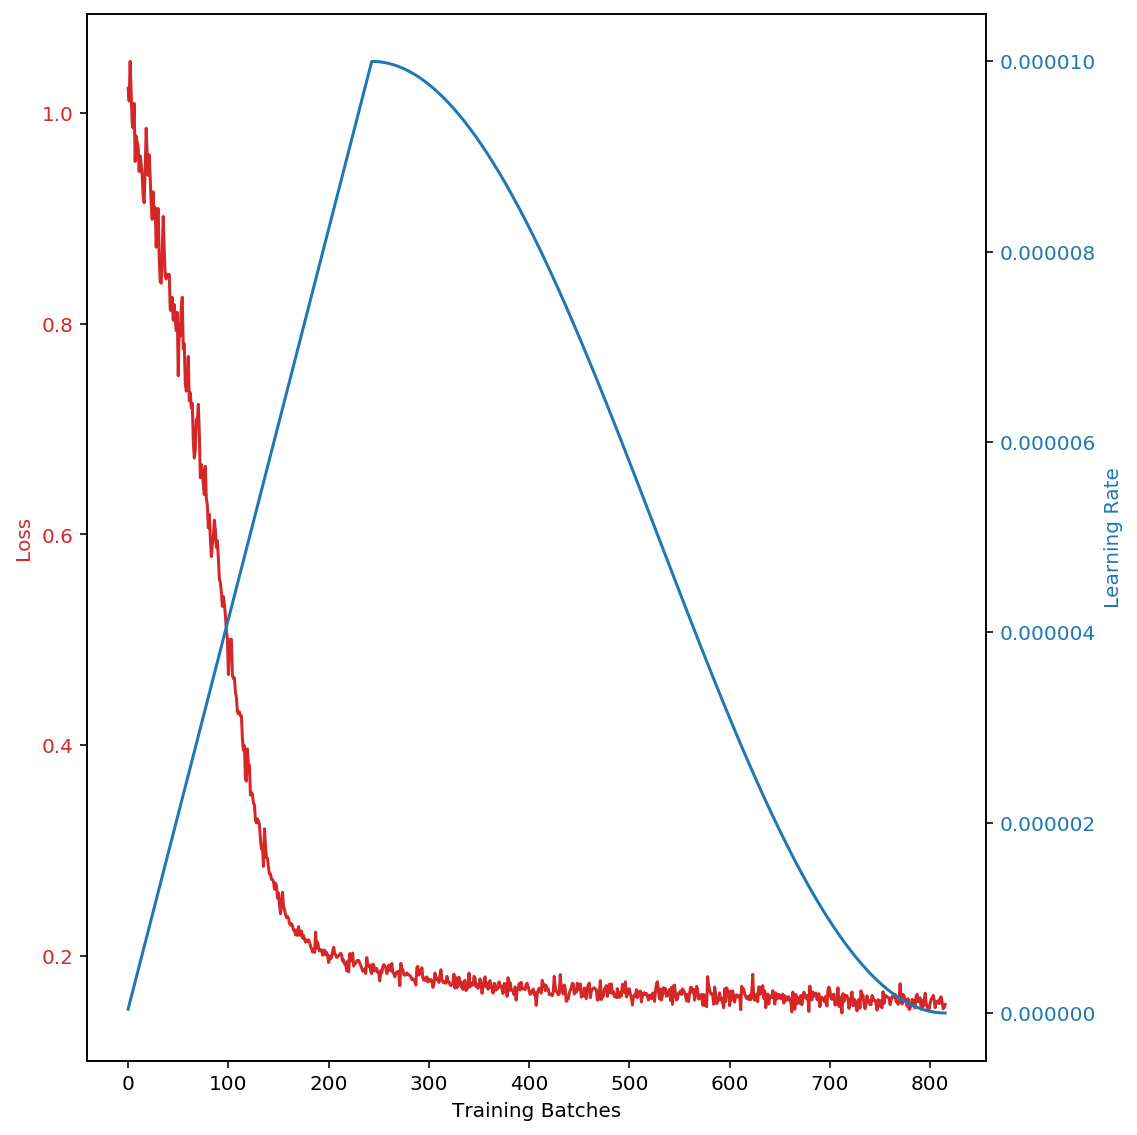

,id,proba,label
433,71063,0.564,1
493,84325,0.416,0
300,48956,0.489,0
418,30849,0.601,1
10,43728,0.426,0
30,83720,0.735,1
802,65297,0.599,1
218,3968,0.644,1
965,7451,0.345,0
80,15473,0.345,0


In [19]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.75,
                              dropout=0.25,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

epochs = 24
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs,
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched, validation_epochs=[2, 5, 7],
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(10)

# 0.6723


In [ ]:
# What train-auc does we achieve if all examples have same score.
# What train-auc does we achieve if all examples have random score.

In [ ]:
submission.sample(10)